# VERSION 1

## Importaciones

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

## Importar los datos

In [18]:
data_world = pd.read_csv("world_generation.csv").set_index("Year")
data_world.index=pd.to_datetime(data_world.index, format='%Y')
data_world.head()

,Electricity generation - TWh
Year,
1985-01-01,9886.064
1986-01-01,10180.790
1987-01-01,10670.628
1988-01-01,11140.627
1989-01-01,11657.959


## Datos de entrenamiento

In [43]:
train_size = 0.75
index = round(train_size*data_world.shape[0])
df_train = data_world.iloc[:index]
df_test = data_world.iloc[index:]

df_train.tail()  # Hasta el 2007

,Electricity generation - TWh
Year,
2009-01-01,19941.40
2010-01-01,21263.27
2011-01-01,21957.08
2012-01-01,22515.84
2013-01-01,23155.39


In [46]:
df_test.shape[0]

10

## Escalado y logaritmo natural


In [84]:
# Suponiendo que df_train ya está definido y contiene la columna 'Electricity generation - TWh'
data_scaled = df_train.copy()
scaler = MinMaxScaler()
# Aplicar transformación logarítmica y escalado Min-Max a la serie original
data_scaled['Electricity generation - TWh'] = np.log1p(data_scaled['Electricity generation - TWh'])
data_scaled['Electricity generation - TWh'] = scaler.fit_transform(data_scaled[['Electricity generation - TWh']])

data_scaled.head()   # Data Train Scaled

,Electricity generation - TWh
Year,
1985-01-01,0.000000
1986-01-01,0.034515
1987-01-01,0.089727
1988-01-01,0.140370
1989-01-01,0.193701


## Gráfica de entrenamiento original y escalado

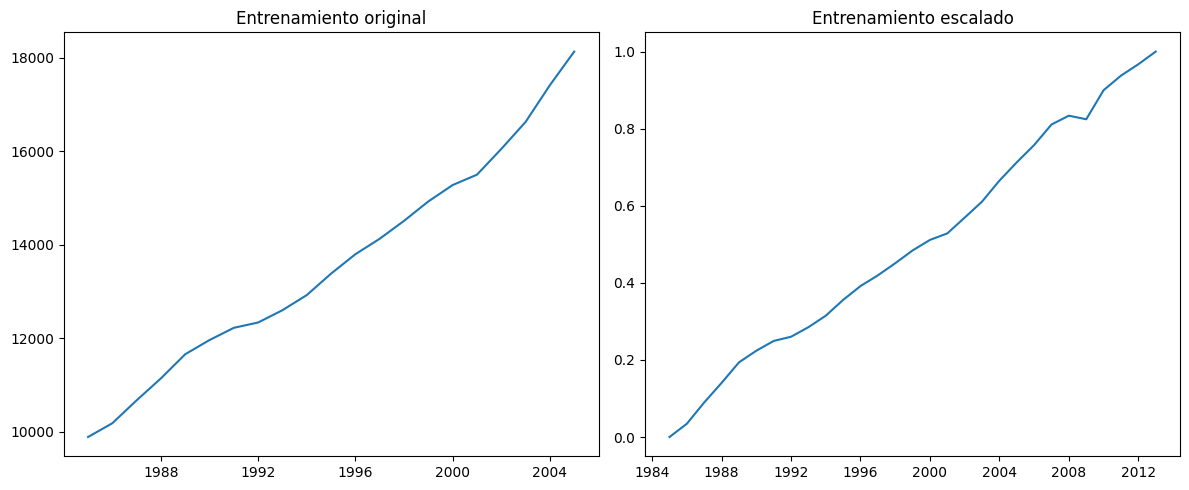

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas

# Gráfico del entrenamiento original
axes[0].plot(data_world.iloc[0:21, :])
axes[0].set_title("Entrenamiento original")

# Gráfico del entrenamiento escalado
axes[1].plot(data_scaled)
axes[1].set_title("Entrenamiento escalado")

plt.tight_layout()  # Ajusta los espacios entre gráficos
plt.show()


## Modelamiento autoarima

In [51]:
# Ajustar modelo ARIMA a la serie transformada (auto_arima ya devuelve el modelo ajustado)
model = pm.auto_arima(
    data_scaled['Electricity generation - TWh'],
    start_p=1, start_d=1, start_q=1,
    max_p=3, max_d=2, max_q=3,
    start_P=0, seasonal=True, m=12
)


## Residuos y gráfica

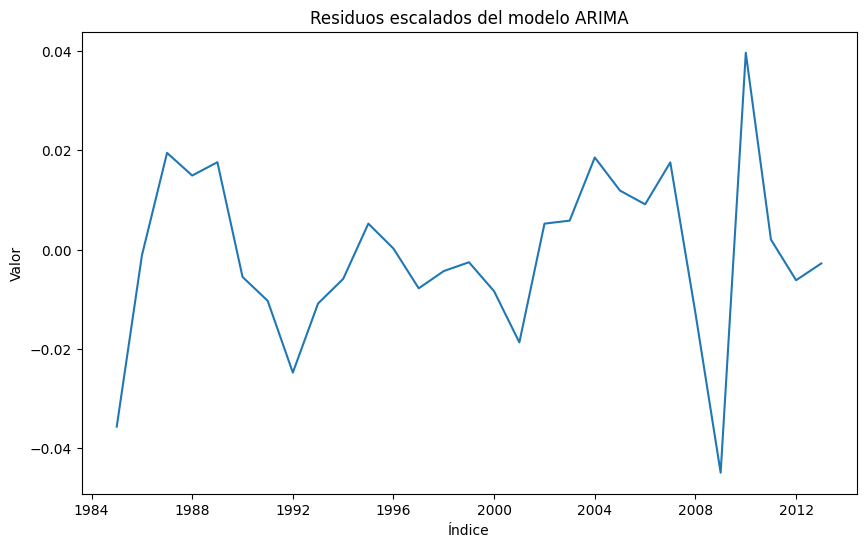

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   29
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  76.160
Date:                Sun, 16 Feb 2025   AIC                           -148.320
Time:                        13:36:35   BIC                           -145.656
Sample:                    01-01-1985   HQIC                          -147.505
                         - 01-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0357      0.003     11.761      0.000       0.030       0.042
sigma2         0.0003   5.37e-05      4.736      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.13   Jarque-

In [52]:
# Obtener los residuos del modelo
residuos = model.resid()

# Gráfico de los residuos escalados
plt.figure(figsize=(10, 6))
plt.plot(residuos)
plt.title('Residuos escalados del modelo ARIMA')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.show()
print(model.summary())

## Predicción

In [ ]:
forecast = model.predict(n_periods=df_test.shape[0])

## Desescalado y exp

In [54]:
f= scaler.inverse_transform(forecast.to_frame())    # Retroceder el MinMaxScaler
dato_real = pd.DataFrame(np.exp(f),columns=['Electricity generation - TWh'],index=forecast.index) # Retroceder el logaritmo
dato_real

,Electricity generation - TWh
2014-01-01,23871.020223
2015-01-01,24607.704676
2016-01-01,25367.123975
2017-01-01,26149.979742
2018-01-01,26956.995251
2019-01-01,27788.916095
2020-01-01,28646.510880
2021-01-01,29530.571929
2022-01-01,30441.916020
2023-01-01,31381.385136


## Comparación de la predicción con datos de test

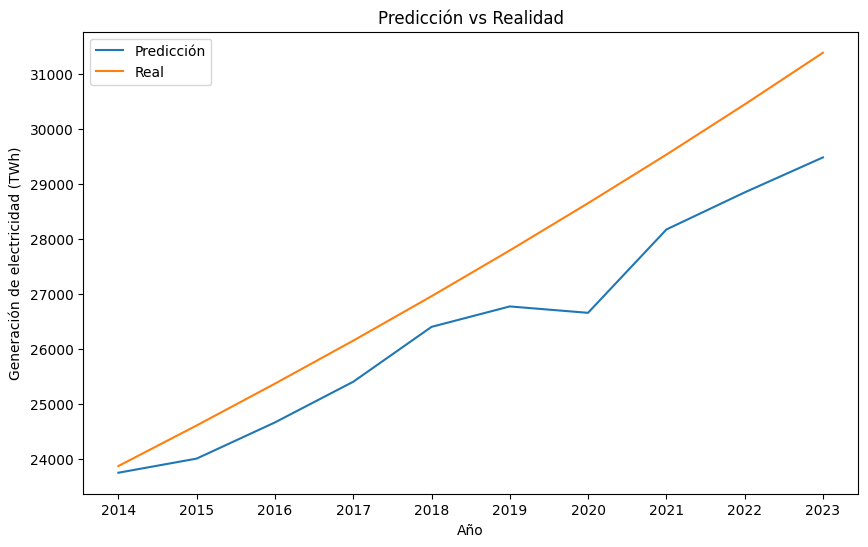

In [55]:
# Comparacion  grafica de Datos Test con Datos Prediccion (Forecast)
# Crear un gráfico de línea con seaborn
plt.figure(figsize=(10,6))
sns.lineplot(x=df_test.index, y=df_test['Electricity generation - TWh'], label='Predicción')
sns.lineplot(x=dato_real.index, y=dato_real['Electricity generation - TWh'], label='Real')
# Agregar título y etiquetas
plt.title('Predicción vs Realidad')
plt.xlabel('Año')
plt.ylabel('Generación de electricidad (TWh)')
# Agregar leyenda
plt.legend()
# Mostrar el gráfico
plt.show()

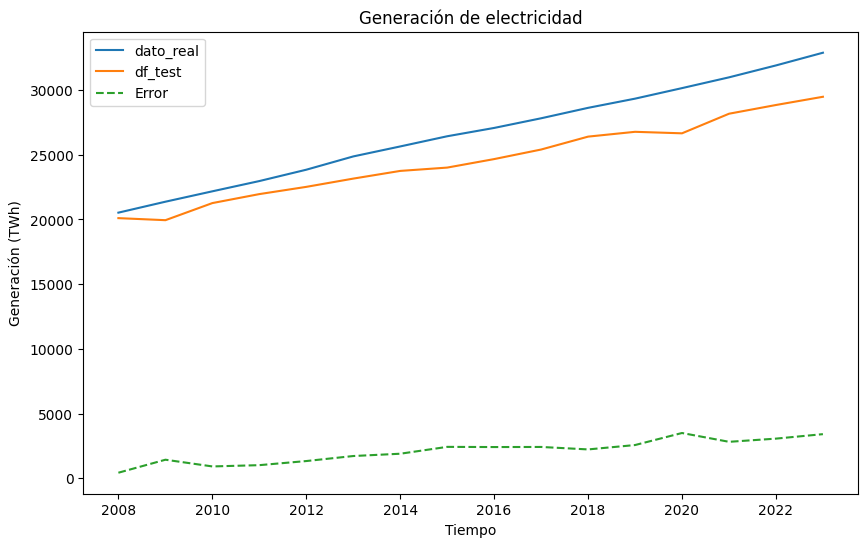

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un gráfico de líneas
plt.figure(figsize=(10, 6))

# Gráfico de dato_real y df_test
sns.lineplot(data=dato_real['Electricity generation - TWh'], label='dato_real')
sns.lineplot(data=df_test['Electricity generation - TWh'], label='df_test')

# Gráfico de la diferencia entre dato_real y df_test
sns.lineplot(data=dato_real['Electricity generation - TWh'] - df_test['Electricity generation - TWh'], label='Error', linestyle='--')

# Personalizar el gráfico
plt.title('Generación de electricidad')
plt.xlabel('Tiempo')
plt.ylabel('Generación (TWh)')
plt.legend()

# Mostrar el gráfico
plt.show()

In [133]:
from sklearn.metrics import r2_score, mean_squared_error

# Calcular el R²
r2 = r2_score(df_test['Electricity generation - TWh'],dato_real['Electricity generation - TWh'])
print("R²:", r2)

# Calcular el MSE
mse = mean_squared_error(df_test['Electricity generation - TWh'],dato_real['Electricity generation - TWh'])
print("MSE:", mse)

R²: 0.5845981051800395
MSE: 1476918.892494571


In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [114]:
data_sc_sarimax = df_train.copy()
#scaler = MinMaxScaler()
# Aplicar transformación logarítmica y escalado Min-Max a la serie original
#data_sc_sarimax['Electricity generation - TWh'] = np.log1p(data_scaled['Electricity generation - TWh'])
data_sc_sarimax['Electricity generation - TWh'] = scaler.fit_transform(data_sc_sarimax[['Electricity generation - TWh']])


In [115]:
smodel = pm.auto_arima(data_sc_sarimax, seasonal=True, m=12,
                       start_p=0, max_p=4, max_d=3, start_q=0, max_q=4,
                       start_P=0, max_P=4, max_D=3, start_Q=0, max_Q=4,
                       trace=True, error_action='ignore', suppress_warnings=True)


Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=-116.022, Time=0.08 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=-117.533, Time=3.88 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=-126.411, Time=3.21 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=-128.282, Time=0.06 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=-126.437, Time=1.50 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=-124.496, Time=9.60 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=-124.511, Time=0.08 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=-126.323, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=-119.531, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=-124.552, Time=0.17 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=-129.305, Time=0.06 sec
 ARIMA(0,2,1)(1,0,0)[12] intercept   : AIC=-127.437, Time=1.56 sec
 ARIMA(0,2,1)(0,0,1)[12] intercept   : AIC=inf, Time=6.65 sec
 ARIMA(0,2,1)(1,0,1)[12] intercept   : AIC=inf, Time=10.04 sec
 ARIMA(0,2,0)(0,0,0)[12] int

In [125]:
sarima = SARIMAX(data_scaled, order=(0,2,1), seasonal_order=(0,0,0, 12))
sarima = sarima.fit(maxiter=70)

/home/juanlewagon/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/juanlewagon/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.39619D+00    |proj g|=  6.69569D+00

At iterate    5    f= -2.40129D+00    |proj g|=  2.41178D-01

At iterate   10    f= -2.40339D+00    |proj g|=  4.24467D+00

At iterate   15    f= -2.45326D+00    |proj g|=  1.65212D+00

At iterate   20    f= -2.45747D+00    |proj g|=  3.35580D-02

At iterate   25    f= -2.45788D+00    |proj g|=  2.27935D-01

At iterate   30    f= -2.45798D+00    |proj g|=  4.31590D-01
  ys=-2.136E-11  -gs= 1.206E-08 BFGS update SKIPPED

At iterate   35    f= -2.45803D+00    |proj g|=  6.48145D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [126]:
#forecast_sarima = sarima.predict(n_periods=df_test.shape[0])
forecast_sarima = sarima.get_forecast(steps=df_test.shape[0],alpha=0.05)
forecast_sarima

In [127]:
forecast_sar = forecast_sarima.predicted_mean
forecast_sar

2014-01-01    1.035714
2015-01-01    1.071429
2016-01-01    1.107143
2017-01-01    1.142857
2018-01-01    1.178572
2019-01-01    1.214286
2020-01-01    1.250001
2021-01-01    1.285715
2022-01-01    1.321429
2023-01-01    1.357144
Freq: AS-JAN, Name: predicted_mean, dtype: float64

In [128]:
forecast_sarima = sarima.get_forecast(steps=df_test.shape[0], alpha=0.05)
forecast_sar = forecast_sarima.predicted_mean
f_sarima = scaler.inverse_transform(forecast_sar.values.reshape(-1, 1))
#dato_real_sarima = pd.DataFrame(np.exp(f_sarima), columns=['Electricity generation - TWh'])
f_sarima = pd.DataFrame(f_sarima, columns=['Electricity generation - TWh'])

f_sarima.index = df_test.index
f_sarima

,Electricity generation - TWh
Year,
2014-01-01,23629.295473
2015-01-01,24103.200945
2016-01-01,24577.106418
2017-01-01,25051.011890
2018-01-01,25524.917363
2019-01-01,25998.822835
2020-01-01,26472.728308
2021-01-01,26946.633780
2022-01-01,27420.539253


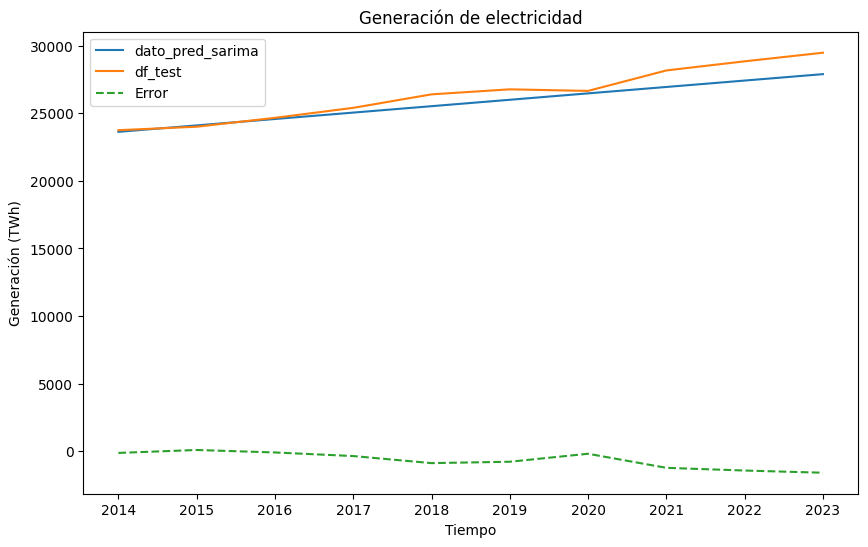

In [129]:
# PLOT Y COMPARACION CON MODELO SARIMAX

plt.figure(figsize=(10, 6))

# Gráfico de dato_real y df_test
sns.lineplot(data=f_sarima['Electricity generation - TWh'], label='dato_pred_sarima')
sns.lineplot(data=df_test['Electricity generation - TWh'], label='df_test')

# Gráfico de la diferencia entre dato_real y df_test
sns.lineplot(data=f_sarima['Electricity generation - TWh'] - df_test['Electricity generation - TWh'], label='Error', linestyle='--')

# Personalizar el gráfico
plt.title('Generación de electricidad')
plt.xlabel('Tiempo')
plt.ylabel('Generación (TWh)')
plt.legend()

# Mostrar el gráfico
plt.show()

In [131]:
# Calcular el R²
r2 = r2_score(df_test['Electricity generation - TWh'],f_sarima['Electricity generation - TWh'])
print("R²:", r2)

# Calcular el MSE
mse = mean_squared_error(f_sarima['Electricity generation - TWh'], df_test['Electricity generation - TWh'])
print("MSE:", mse)

R²: 0.7867292013526661
MSE: 758262.4818699257


# DATOS FILTRADOS DEL DATAFRAME ORIGINAL

DATA ORIGINAL

In [29]:
original_world = pd.read_csv("World Energy Consumption.csv")

LISTA DE NO PAISES

In [ ]:
# Lista de regiones, continentes y agrupaciones económicas identificadas en el dataset
non_countries = ["Africa", "Asia", "Europe", "North America", "South America", "Oceania",
                 "ASEAN (Ember)", "European Union (27)", "World", "High-income countries",
                 "Low-income countries", "Middle-income countries", "G20", "OECD"'Africa (EI)', 'Africa (Ember)', 'Africa (Shift)',
                'Asia & Oceania (EIA)','Asia (Ember)', 'Asia Pacific (EI)','Asia and Oceania (Shift)',
                'Australia and New Zealand (EIA)','CIS (EI)','Central & South America (EIA)', 'Central America (EI)',
                 'Central and South America (Shift)','EU28 (Shift)']
more_non_countries = [
    'Africa (EI)', 'Africa (Ember)', 'Africa (Shift)',
    'Asia & Oceania (EIA)', 'Asia (Ember)', 'Asia Pacific (EI)',
    'Asia and Oceania (Shift)', 'Australia and New Zealand (EIA)',
    'Central & South America (EIA)', 'Central America (EI)',
    'Central and South America (Shift)', 'CIS (EI)', 'EU28 (Shift)', 'Eastern Africa (EI)', 'Eurasia (EIA)',
    'Eurasia (Shift)', 'Europe (EI)', 'Europe (Ember)', 'Europe (Shift)',
    'European Union (EIA)', 'G20 (Ember)', 'G7 (Ember)', 'Hawaiian Trade Zone (EIA)',
    'IEO - Africa (EIA)', 'IEO - Middle East (EIA)', 'IEO OECD - Europe (EIA)',
    'Latin America and Caribbean (Ember)', 'Lower-middle-income countries',
    'Mexico, Chile, and other OECD Americas (EIA)', 'Middle Africa (EI)',
    'Middle East (EI)', 'Middle East (EIA)', 'Middle East (Ember)', 'Middle East (Shift)',
    'Non-OECD (EI)', 'Non-OECD (EIA)', 'Non-OPEC (EI)', 'Non-OPEC (EIA)',
    'North America (EI)', 'North America (Ember)', 'North America (Shift)',
    'OECD (EI)', 'OECD (EIA)', 'OECD (Ember)', 'OECD (Shift)', 'OECD - Asia And Oceania (EIA)',
    'OECD - Europe (EIA)', 'OECD - North America (EIA)', 'OPEC (EI)', 'OPEC (EIA)', 'OPEC (Shift)',
    'OPEC - Africa (EIA)', 'OPEC - South America (EIA)', 'Oceania (Ember)', 'Other Non-OECD - America (EIA)',
    'Other Non-OECD - Asia (EIA)', 'Other Non-OECD - Europe and Eurasia (EIA)', 'Persian Gulf (EIA)',
    'Persian Gulf (Shift)', 'South and Central America (EI)', 'South Korea and other OECD Asia (EIA)',
    'U.S. Pacific Islands (EIA)', 'U.S. Territories (EIA)', 'United States Pacific Islands (Shift)',
    'United States Territories (Shift)', 'Upper-middle-income countries', 'Wake Island (EIA)',
    'Wake Island (Shift)', 'Western Africa (EI)', 'Yugoslavia'
]

no_son_paises = non_countries + more_non_countries

FILTRAR DATA CON COLUMNAS DE INTERES

In [31]:
original_world_filt = original_world[~original_world["country"].isin(no_son_paises)][["year","country","electricity_generation"]]

DATA AGRUPADA Y FILTRADA DESDE 1985

In [32]:
original_world_total = original_world_filt.groupby('year')["electricity_generation"].sum().to_frame('sum_electricity')

In [34]:
original_world_total = original_world_total[original_world_total.index>=1985]
original_world_total.index = pd.to_datetime(original_world_total.index, format='%Y')

DATA FINAL

In [35]:
original_world_total

,sum_electricity
year,
1985-01-01,9549.238
1986-01-01,9821.943
1987-01-01,10293.600
1988-01-01,10742.213
1989-01-01,11254.359
1990-01-01,11599.796
1991-01-01,11856.713
1992-01-01,11974.662
1993-01-01,12239.561
